# Chapter 4: Bayesian Statistics (Working in progress proof of concept)

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../")

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

In [2]:
geo_data = gp.read_pickle('../input_data/BasicFault.pickle')

In [3]:
gp.set_data_series(geo_data, {"fault":geo_data.formations[4], 
                      "Rest":np.delete(geo_data.formations, 4)},
                       order_series = ["fault",
                                       "Rest",
                                       ], verbose=0)

In [4]:
interp_data = gp.InterpolatorInput(geo_data, compile_theano=False, u_grade=[3,3])

I am in the setting
float32
I am here
[2, 2]


In [5]:
input_data_T = interp_data.interpolator.tg.input_parameters_list()
input_data_P = interp_data.get_input_data(u_grade=[3, 3])
select = interp_data.interpolator.pandas_rest_layer_points['formation'] == 'Reservoir'

[3, 3]


In [6]:
import theano
import theano.tensor as T
geomodel = theano.OpFromGraph(input_data_T, [interp_data.interpolator.tg.whole_block_model(1)], on_unused_input='ignore')

Because now the GeMpy model is a theano operation and not a theano function, to call it we need to use theano variables (with theano functions we call them with python variables). This is very easy to modify, we just need to use theano shared to convert our python input data into theano variables.

The pymc3 objects are already theano variables (pm.Normal and so on). Now the trick is that using the theano function T.set_subtensor, we can change one deterministic value of the input arrays(the ones printed in the cell above) by a stochastic pymc3 object. Then with the new arrays we just have to call the theano operation and pymc will do the rest

In [7]:
# This is the creation of the model
import pymc3 as pm
theano.config.compute_test_value = 'off'
model = pm.Model()
with model:
    # Stochastic value
    reservoir = pm.Normal('reservoir', np.array([0], dtype='float64')
                          , sd=np.array([0.09], dtype='float64'), dtype='float64', shape=(1))
    
    # We convert a python variable to theano.shared
    ref = theano.shared(input_data_P[4])
    rest = theano.shared(input_data_P[5])
    
    # We add the stochastic value to the correspondant array
    ref = pm.Deterministic('reference', T.set_subtensor(
       ref[T.nonzero(T.cast(select.as_matrix(), "int8"))[0], 2],
       ref[T.nonzero(T.cast(select.as_matrix(), "int8"))[0], 2]+reservoir))
    rest = pm.Deterministic('rest', T.set_subtensor(
        rest[T.nonzero(T.cast(select.as_matrix(), "int8"))[0], 2],
        rest[T.nonzero(T.cast(select.as_matrix(), "int8"))[0], 2]+reservoir))#
  
    geo_model = pm.Deterministic('GeMpy', geomodel(theano.shared(input_data_P[0]),
                                                  theano.shared(input_data_P[1]),
                                                  theano.shared(input_data_P[2]),
                                                  theano.shared(input_data_P[3]),
                                                  ref, rest))

reservoir <class 'pymc3.model.FreeRV'>


In [8]:
theano.config.compute_test_value = 'ignore'
# This is the sampling
# BEFORE RUN THIS FOR LONG CHECK IN THE MODULE THEANOGRAF THAT THE FLAG THEANO OPTIMIZER IS IN 'fast_run'!!
with model:
   # backend = pm.backends.ndarray.NDArray('geomodels')
    step = pm.NUTS()
    trace = pm.sample(30, init=None, step=step, )

100%|██████████| 30/30 [01:11<00:00,  1.90s/it]


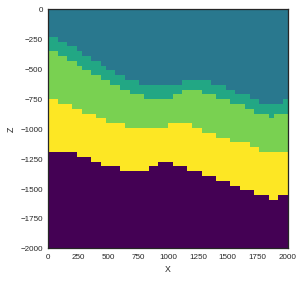

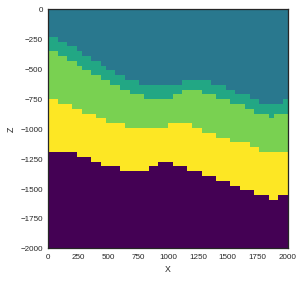

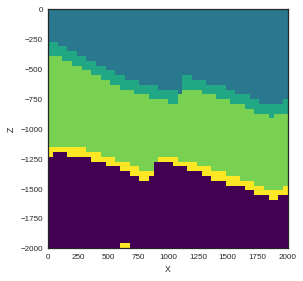

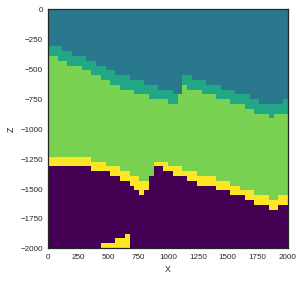

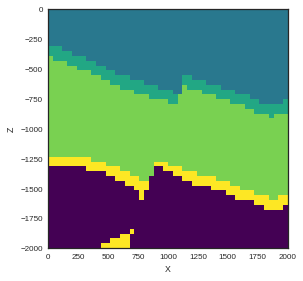

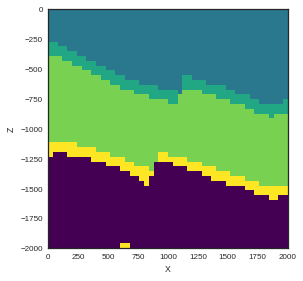

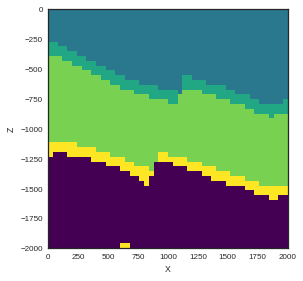

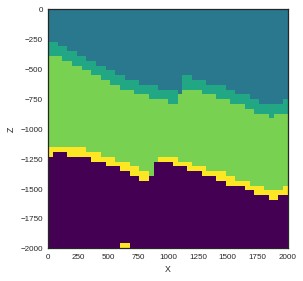

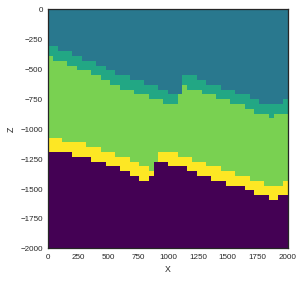

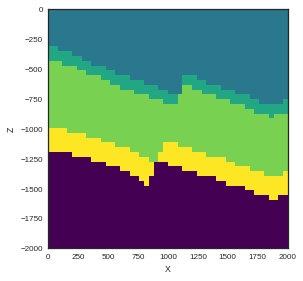

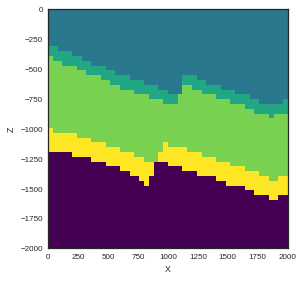

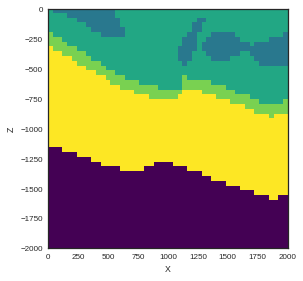

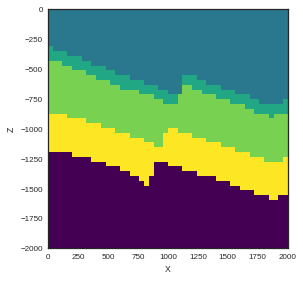

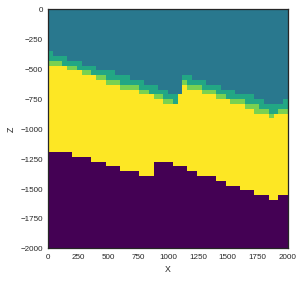

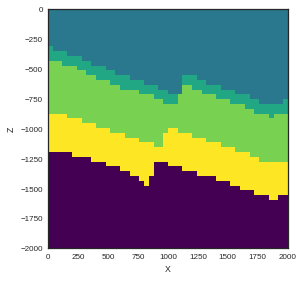

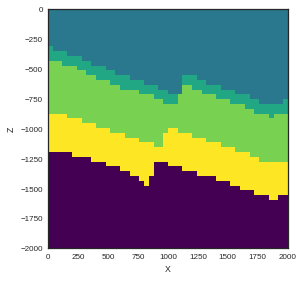

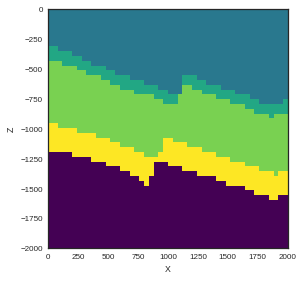

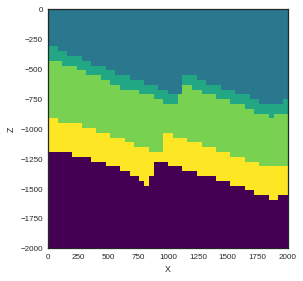

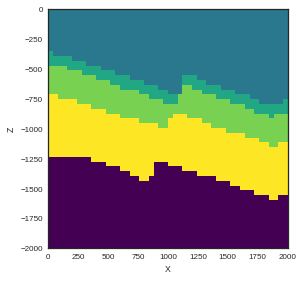

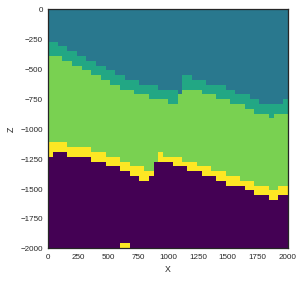

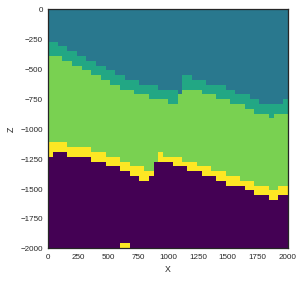

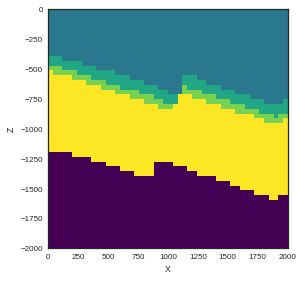

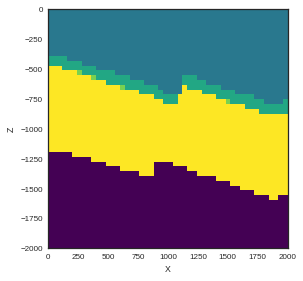

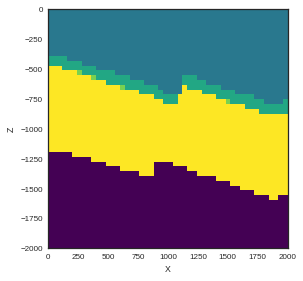

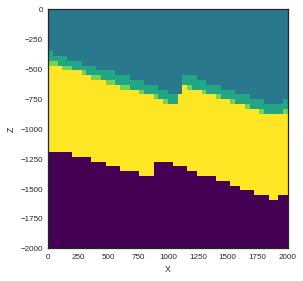

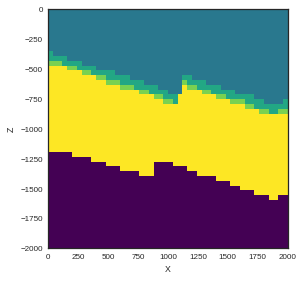

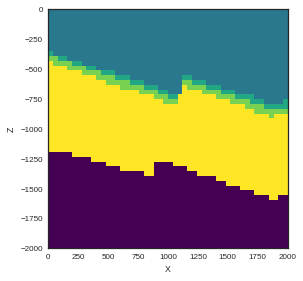

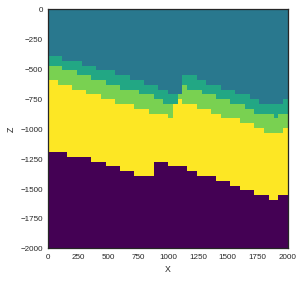

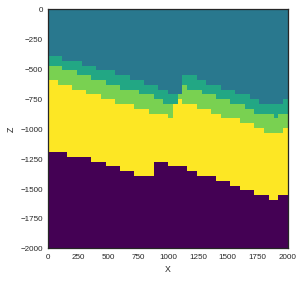

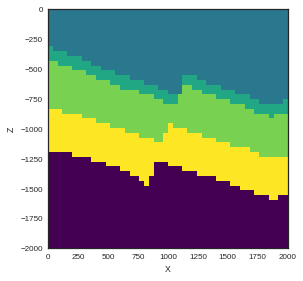

IndexError: index 30 is out of bounds for axis 0 with size 30

In [13]:
import matplotlib.pyplot as plt
for i in range(100):
    gp.plot_section(geo_data, trace.get_values('GeMpy')[i][0, 0, :], 25,
                       direction='y', plot_data=False)
    plt.show()